In [1]:
from tensorflow.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt


In [3]:
# 1. 데이터 생성하기
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(32, 32),
        batch_size=3,
        class_mode='binary') 

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(32, 32),     
        batch_size=3,
        class_mode='binary')

Found 1052 images belonging to 2 classes.
Found 239 images belonging to 2 classes.


In [9]:
# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', input_shape=(32,32, 3)))
model.add(Conv2D(32, (3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid')) 


# 3. 모델 학습과정 설정하기
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001)
#                  ,loss=tf.keras.losses.binary_crossentropy
#                  ,metrics=[tf.keras.metrics.Precision(name='precision')\
#                           ,tf.keras.metrics.Recall(name='recall')\
#                           ,tf.keras.metrics.FalsePositives(name='false_positives')\
#                           ,tf.keras.metrics.FalseNegatives(name='false_negatives')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score])

early_stopping = EarlyStopping(patience=10) 

# 4. 모델 학습시키기
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=50, 
        epochs=500,  
        validation_data=test_generator,
        validation_steps=5,
        ) 

_loss, _acc, _precision, _recall, _f1score = model.evaluate_generator(test_generator, steps=5)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))


# # 5. 모델 평가하기
# print("-- Evaluate --")
# scores = model.evaluate_generator(test_generator, steps=5)
# print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# # 6. 모델 사용하기
# print("-- Predict --")
# output = model.predict_generator(test_generator, steps=5)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# print(test_generator.class_indices)
# print(output)

Epoch 1/500
50/50 [==============================] - 2s 17ms/step - loss: 0.9894 - accuracy: 0.5161 - precision: 0.3928 - recall: 0.5016 - f1score: 0.4026 - val_loss: 0.6554 - val_accuracy: 0.6000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/500
50/50 [==============================] - 1s 12ms/step - loss: 0.7089 - accuracy: 0.6304 - precision: 0.1249 - recall: 0.1230 - f1score: 0.1158 - val_loss: 0.9154 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 3/500
50/50 [==============================] - 1s 14ms/step - loss: 0.7859 - accuracy: 0.5164 - precision: 0.1961 - recall: 0.3223 - f1score: 0.2328 - val_loss: 0.5890 - val_accuracy: 0.6667 - val_precision: 0.2000 - val_recall: 0.2000 - val_f1score: 0.2000
Epoch 4/500
50/50 [==============================] - 1s 13ms/step - loss: 0.6980 - accuracy: 0.6011 - precision: 0.0769 - recall: 0.1182 - f1score: 0.0880 - val_loss: 0.5715 - val_accu

Epoch 32/500
50/50 [==============================] - 1s 18ms/step - loss: 0.7332 - accuracy: 0.7281 - precision: 0.6074 - recall: 0.5457 - f1score: 0.5370 - val_loss: 0.5731 - val_accuracy: 0.8000 - val_precision: 0.4000 - val_recall: 0.3000 - val_f1score: 0.3333
Epoch 33/500
50/50 [==============================] - 1s 16ms/step - loss: 0.4867 - accuracy: 0.8079 - precision: 0.4917 - recall: 0.4532 - f1score: 0.4516 - val_loss: 0.4900 - val_accuracy: 0.8667 - val_precision: 0.4000 - val_recall: 0.4000 - val_f1score: 0.4000
Epoch 34/500
50/50 [==============================] - 1s 14ms/step - loss: 0.5093 - accuracy: 0.7807 - precision: 0.6849 - recall: 0.6801 - f1score: 0.6578 - val_loss: 0.3149 - val_accuracy: 0.9333 - val_precision: 0.9000 - val_recall: 1.0000 - val_f1score: 0.9333
Epoch 35/500
50/50 [==============================] - 1s 14ms/step - loss: 0.5342 - accuracy: 0.7626 - precision: 0.5968 - recall: 0.7040 - f1score: 0.6268 - val_loss: 0.5676 - val_accuracy: 0.7333 - val_p

Epoch 63/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3565 - accuracy: 0.8509 - precision: 0.6394 - recall: 0.6488 - f1score: 0.6290 - val_loss: 0.7981 - val_accuracy: 0.4667 - val_precision: 0.2000 - val_recall: 0.0667 - val_f1score: 0.1000
Epoch 64/500
50/50 [==============================] - 1s 14ms/step - loss: 0.5101 - accuracy: 0.6852 - precision: 0.3677 - recall: 0.3484 - f1score: 0.3347 - val_loss: 0.3836 - val_accuracy: 0.8667 - val_precision: 0.8000 - val_recall: 0.7000 - val_f1score: 0.7333
Epoch 65/500
50/50 [==============================] - 1s 14ms/step - loss: 0.4377 - accuracy: 0.7856 - precision: 0.6920 - recall: 0.7504 - f1score: 0.6971 - val_loss: 0.5909 - val_accuracy: 0.5333 - val_precision: 0.3000 - val_recall: 0.3000 - val_f1score: 0.3000
Epoch 66/500
50/50 [==============================] - 1s 16ms/step - loss: 0.4882 - accuracy: 0.7914 - precision: 0.5301 - recall: 0.4432 - f1score: 0.4706 - val_loss: 0.4624 - val_accuracy: 0.7333 - val_p

Epoch 94/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3676 - accuracy: 0.8408 - precision: 0.6877 - recall: 0.7336 - f1score: 0.6933 - val_loss: 0.7325 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 95/500
50/50 [==============================] - 1s 13ms/step - loss: 0.4376 - accuracy: 0.8036 - precision: 0.7413 - recall: 0.6896 - f1score: 0.6914 - val_loss: 0.2645 - val_accuracy: 0.9333 - val_precision: 0.6000 - val_recall: 0.6000 - val_f1score: 0.6000
Epoch 96/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3541 - accuracy: 0.8716 - precision: 0.6008 - recall: 0.6001 - f1score: 0.5867 - val_loss: 0.4561 - val_accuracy: 0.7333 - val_precision: 0.6000 - val_recall: 0.5333 - val_f1score: 0.5600
Epoch 97/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3863 - accuracy: 0.8178 - precision: 0.5614 - recall: 0.5244 - f1score: 0.5289 - val_loss: 0.2423 - val_accuracy: 0.

Epoch 125/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3514 - accuracy: 0.8548 - precision: 0.7097 - recall: 0.6672 - f1score: 0.6677 - val_loss: 0.0774 - val_accuracy: 1.0000 - val_precision: 0.6000 - val_recall: 0.6000 - val_f1score: 0.6000
Epoch 126/500
50/50 [==============================] - 1s 13ms/step - loss: 0.2701 - accuracy: 0.8615 - precision: 0.7413 - recall: 0.7559 - f1score: 0.7362 - val_loss: 0.4385 - val_accuracy: 0.8000 - val_precision: 0.6000 - val_recall: 0.4000 - val_f1score: 0.4667
Epoch 127/500
50/50 [==============================] - 1s 13ms/step - loss: 0.3823 - accuracy: 0.8289 - precision: 0.6261 - recall: 0.6046 - f1score: 0.6033 - val_loss: 0.4103 - val_accuracy: 0.8000 - val_precision: 0.5333 - val_recall: 0.5000 - val_f1score: 0.4933
Epoch 128/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3344 - accuracy: 0.8418 - precision: 0.6882 - recall: 0.6547 - f1score: 0.6440 - val_loss: 0.3109 - val_accuracy: 0.8667 - v

Epoch 156/500
50/50 [==============================] - 1s 14ms/step - loss: 0.4372 - accuracy: 0.8363 - precision: 0.6449 - recall: 0.5957 - f1score: 0.5897 - val_loss: 0.6687 - val_accuracy: 0.7333 - val_precision: 0.4000 - val_recall: 0.1333 - val_f1score: 0.2000
Epoch 157/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3102 - accuracy: 0.8484 - precision: 0.7140 - recall: 0.6091 - f1score: 0.6361 - val_loss: 0.2934 - val_accuracy: 0.8667 - val_precision: 0.7333 - val_recall: 0.8000 - val_f1score: 0.7600
Epoch 158/500
50/50 [==============================] - 1s 13ms/step - loss: 0.3120 - accuracy: 0.8725 - precision: 0.7945 - recall: 0.7711 - f1score: 0.7676 - val_loss: 0.1968 - val_accuracy: 0.8667 - val_precision: 0.8000 - val_recall: 0.7000 - val_f1score: 0.7333
Epoch 159/500
50/50 [==============================] - 1s 14ms/step - loss: 0.2936 - accuracy: 0.8718 - precision: 0.7478 - recall: 0.7158 - f1score: 0.7150 - val_loss: 0.6203 - val_accuracy: 0.6000 - v

Epoch 187/500
50/50 [==============================] - 1s 13ms/step - loss: 0.3172 - accuracy: 0.9041 - precision: 0.6628 - recall: 0.7475 - f1score: 0.6896 - val_loss: 0.0254 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1score: 1.0000
Epoch 188/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3122 - accuracy: 0.8484 - precision: 0.6481 - recall: 0.6949 - f1score: 0.6570 - val_loss: 0.4820 - val_accuracy: 0.7333 - val_precision: 0.6000 - val_recall: 0.5333 - val_f1score: 0.5600
Epoch 189/500
50/50 [==============================] - 1s 15ms/step - loss: 0.1899 - accuracy: 0.9399 - precision: 0.6146 - recall: 0.6354 - f1score: 0.6185 - val_loss: 0.1561 - val_accuracy: 0.9333 - val_precision: 1.0000 - val_recall: 0.9333 - val_f1score: 0.9600
Epoch 190/500
50/50 [==============================] - 1s 14ms/step - loss: 0.2303 - accuracy: 0.9034 - precision: 0.7814 - recall: 0.8305 - f1score: 0.7948 - val_loss: 0.6811 - val_accuracy: 0.8000 - v

Epoch 218/500
50/50 [==============================] - 1s 15ms/step - loss: 0.2945 - accuracy: 0.8384 - precision: 0.6546 - recall: 0.6572 - f1score: 0.6430 - val_loss: 0.8527 - val_accuracy: 0.6667 - val_precision: 0.4000 - val_recall: 0.4000 - val_f1score: 0.4000
Epoch 219/500
50/50 [==============================] - 1s 16ms/step - loss: 0.3015 - accuracy: 0.8258 - precision: 0.8641 - recall: 0.7483 - f1score: 0.7763 - val_loss: 0.1610 - val_accuracy: 0.8667 - val_precision: 0.8000 - val_recall: 0.7000 - val_f1score: 0.7333
Epoch 220/500
50/50 [==============================] - 1s 17ms/step - loss: 0.4778 - accuracy: 0.8057 - precision: 0.6577 - recall: 0.6992 - f1score: 0.6662 - val_loss: 0.3223 - val_accuracy: 0.7333 - val_precision: 0.4000 - val_recall: 0.4000 - val_f1score: 0.4000
Epoch 221/500
50/50 [==============================] - 1s 16ms/step - loss: 0.2759 - accuracy: 0.9029 - precision: 0.6957 - recall: 0.7150 - f1score: 0.6872 - val_loss: 0.2931 - val_accuracy: 0.9333 - v

Epoch 249/500
50/50 [==============================] - 1s 13ms/step - loss: 0.3452 - accuracy: 0.8991 - precision: 0.7825 - recall: 0.7612 - f1score: 0.7554 - val_loss: 0.3571 - val_accuracy: 0.6667 - val_precision: 0.3000 - val_recall: 0.3000 - val_f1score: 0.2667
Epoch 250/500
50/50 [==============================] - 1s 14ms/step - loss: 0.4046 - accuracy: 0.8361 - precision: 0.6654 - recall: 0.6473 - f1score: 0.6363 - val_loss: 0.1813 - val_accuracy: 0.9333 - val_precision: 1.0000 - val_recall: 0.9000 - val_f1score: 0.9333
Epoch 251/500
50/50 [==============================] - 1s 15ms/step - loss: 0.3696 - accuracy: 0.8045 - precision: 0.6019 - recall: 0.6981 - f1score: 0.6232 - val_loss: 0.1656 - val_accuracy: 0.9333 - val_precision: 0.6000 - val_recall: 0.6000 - val_f1score: 0.6000
Epoch 252/500
50/50 [==============================] - 1s 13ms/step - loss: 0.2121 - accuracy: 0.9099 - precision: 0.6550 - recall: 0.6585 - f1score: 0.6486 - val_loss: 0.4730 - val_accuracy: 0.8667 - v

Epoch 280/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3656 - accuracy: 0.8554 - precision: 0.5974 - recall: 0.5694 - f1score: 0.5660 - val_loss: 0.2724 - val_accuracy: 0.8667 - val_precision: 0.7333 - val_recall: 0.8000 - val_f1score: 0.7600
Epoch 281/500
50/50 [==============================] - 1s 13ms/step - loss: 0.3662 - accuracy: 0.8847 - precision: 0.7411 - recall: 0.7275 - f1score: 0.7129 - val_loss: 0.2861 - val_accuracy: 0.9333 - val_precision: 0.9000 - val_recall: 1.0000 - val_f1score: 0.9333
Epoch 282/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3298 - accuracy: 0.8957 - precision: 0.8186 - recall: 0.8172 - f1score: 0.8009 - val_loss: 0.3969 - val_accuracy: 0.7333 - val_precision: 0.5667 - val_recall: 0.8000 - val_f1score: 0.6533
Epoch 283/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3080 - accuracy: 0.9088 - precision: 0.7916 - recall: 0.7986 - f1score: 0.7816 - val_loss: 0.5059 - val_accuracy: 0.8000 - v

Epoch 311/500
50/50 [==============================] - 1s 15ms/step - loss: 0.1979 - accuracy: 0.8902 - precision: 0.6650 - recall: 0.6917 - f1score: 0.6594 - val_loss: 0.3849 - val_accuracy: 0.9333 - val_precision: 0.6000 - val_recall: 0.6000 - val_f1score: 0.6000
Epoch 312/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3893 - accuracy: 0.8464 - precision: 0.7244 - recall: 0.6607 - f1score: 0.6801 - val_loss: 0.5929 - val_accuracy: 0.8667 - val_precision: 0.1333 - val_recall: 0.2000 - val_f1score: 0.1600
Epoch 313/500
50/50 [==============================] - 1s 12ms/step - loss: 0.2721 - accuracy: 0.9128 - precision: 0.7382 - recall: 0.7158 - f1score: 0.7188 - val_loss: 0.3166 - val_accuracy: 0.8000 - val_precision: 0.6000 - val_recall: 0.5000 - val_f1score: 0.5333
Epoch 314/500
50/50 [==============================] - 1s 14ms/step - loss: 0.5061 - accuracy: 0.8099 - precision: 0.6305 - recall: 0.6595 - f1score: 0.6255 - val_loss: 0.6303 - val_accuracy: 0.8000 - v

Epoch 342/500
50/50 [==============================] - 1s 14ms/step - loss: 0.4399 - accuracy: 0.7934 - precision: 0.6780 - recall: 0.6520 - f1score: 0.6428 - val_loss: 0.5732 - val_accuracy: 0.8667 - val_precision: 0.8000 - val_recall: 0.7000 - val_f1score: 0.7333
Epoch 343/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3177 - accuracy: 0.8559 - precision: 0.7747 - recall: 0.7511 - f1score: 0.7523 - val_loss: 0.4242 - val_accuracy: 0.8667 - val_precision: 0.9000 - val_recall: 0.9000 - val_f1score: 0.9000
Epoch 344/500
50/50 [==============================] - 1s 13ms/step - loss: 0.4171 - accuracy: 0.8766 - precision: 0.6797 - recall: 0.7432 - f1score: 0.6974 - val_loss: 0.2174 - val_accuracy: 0.9333 - val_precision: 1.0000 - val_recall: 0.9333 - val_f1score: 0.9600
Epoch 345/500
50/50 [==============================] - 1s 14ms/step - loss: 0.2362 - accuracy: 0.9368 - precision: 0.7753 - recall: 0.7435 - f1score: 0.7512 - val_loss: 0.5623 - val_accuracy: 0.7333 - v

Epoch 373/500
50/50 [==============================] - 1s 13ms/step - loss: 0.3439 - accuracy: 0.8730 - precision: 0.7193 - recall: 0.7579 - f1score: 0.7186 - val_loss: 0.2845 - val_accuracy: 0.8000 - val_precision: 0.5000 - val_recall: 0.6000 - val_f1score: 0.5333
Epoch 374/500
50/50 [==============================] - 1s 13ms/step - loss: 0.2416 - accuracy: 0.9297 - precision: 0.8580 - recall: 0.8525 - f1score: 0.8424 - val_loss: 0.1790 - val_accuracy: 0.9333 - val_precision: 0.9000 - val_recall: 1.0000 - val_f1score: 0.9333
Epoch 375/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3283 - accuracy: 0.8524 - precision: 0.7694 - recall: 0.7531 - f1score: 0.7426 - val_loss: 0.6424 - val_accuracy: 0.6667 - val_precision: 0.2000 - val_recall: 0.1000 - val_f1score: 0.1333
Epoch 376/500
50/50 [==============================] - 1s 14ms/step - loss: 0.2598 - accuracy: 0.8906 - precision: 0.8096 - recall: 0.8041 - f1score: 0.7863 - val_loss: 0.6597 - val_accuracy: 0.8000 - v

Epoch 404/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3290 - accuracy: 0.8518 - precision: 0.6109 - recall: 0.6151 - f1score: 0.5974 - val_loss: 0.9834 - val_accuracy: 0.6667 - val_precision: 0.2000 - val_recall: 0.1333 - val_f1score: 0.1600
Epoch 405/500
50/50 [==============================] - 1s 13ms/step - loss: 0.4060 - accuracy: 0.8930 - precision: 0.5735 - recall: 0.5206 - f1score: 0.5367 - val_loss: 0.7907 - val_accuracy: 0.6000 - val_precision: 0.2000 - val_recall: 0.2000 - val_f1score: 0.2000
Epoch 406/500
50/50 [==============================] - 1s 14ms/step - loss: 0.4336 - accuracy: 0.8335 - precision: 0.5371 - recall: 0.4462 - f1score: 0.4706 - val_loss: 0.1764 - val_accuracy: 0.9333 - val_precision: 0.4000 - val_recall: 0.4000 - val_f1score: 0.4000
Epoch 407/500
50/50 [==============================] - 1s 14ms/step - loss: 0.4788 - accuracy: 0.8167 - precision: 0.6326 - recall: 0.6301 - f1score: 0.5947 - val_loss: 0.6491 - val_accuracy: 0.7333 - v

Epoch 435/500
50/50 [==============================] - 1s 15ms/step - loss: 0.3501 - accuracy: 0.9177 - precision: 0.7000 - recall: 0.6676 - f1score: 0.6654 - val_loss: 0.8431 - val_accuracy: 0.7333 - val_precision: 0.8000 - val_recall: 0.6667 - val_f1score: 0.7000
Epoch 436/500
50/50 [==============================] - 1s 13ms/step - loss: 0.2563 - accuracy: 0.8754 - precision: 0.6032 - recall: 0.6475 - f1score: 0.6135 - val_loss: 1.0474 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.8000 - val_f1score: 0.8667
Epoch 437/500
50/50 [==============================] - 1s 13ms/step - loss: 0.2914 - accuracy: 0.8497 - precision: 0.5907 - recall: 0.5937 - f1score: 0.5804 - val_loss: 0.4394 - val_accuracy: 0.9333 - val_precision: 0.7000 - val_recall: 0.8000 - val_f1score: 0.7333
Epoch 438/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3641 - accuracy: 0.8329 - precision: 0.6738 - recall: 0.6710 - f1score: 0.6491 - val_loss: 0.0974 - val_accuracy: 0.9333 - v

Epoch 466/500
50/50 [==============================] - 1s 15ms/step - loss: 0.2134 - accuracy: 0.9234 - precision: 0.6560 - recall: 0.6361 - f1score: 0.6382 - val_loss: 0.1666 - val_accuracy: 1.0000 - val_precision: 0.8000 - val_recall: 0.8000 - val_f1score: 0.8000
Epoch 467/500
50/50 [==============================] - 1s 16ms/step - loss: 0.2526 - accuracy: 0.9140 - precision: 0.7298 - recall: 0.7592 - f1score: 0.7322 - val_loss: 0.1050 - val_accuracy: 0.9333 - val_precision: 0.8000 - val_recall: 0.7000 - val_f1score: 0.7333
Epoch 468/500
50/50 [==============================] - 1s 13ms/step - loss: 0.2624 - accuracy: 0.8814 - precision: 0.7630 - recall: 0.7148 - f1score: 0.7282 - val_loss: 0.1110 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1score: 1.0000
Epoch 469/500
50/50 [==============================] - 1s 13ms/step - loss: 0.2617 - accuracy: 0.8798 - precision: 0.6922 - recall: 0.6514 - f1score: 0.6503 - val_loss: 0.4580 - val_accuracy: 0.6667 - v

Epoch 497/500
50/50 [==============================] - 1s 14ms/step - loss: 0.4223 - accuracy: 0.8312 - precision: 0.7541 - recall: 0.7077 - f1score: 0.7111 - val_loss: 0.4509 - val_accuracy: 0.9333 - val_precision: 0.8000 - val_recall: 0.7000 - val_f1score: 0.7333
Epoch 498/500
50/50 [==============================] - 1s 14ms/step - loss: 0.3531 - accuracy: 0.8378 - precision: 0.6099 - recall: 0.6522 - f1score: 0.6173 - val_loss: 0.2424 - val_accuracy: 0.8667 - val_precision: 0.8000 - val_recall: 1.0000 - val_f1score: 0.8667
Epoch 499/500
50/50 [==============================] - 1s 14ms/step - loss: 0.1894 - accuracy: 0.9296 - precision: 0.8102 - recall: 0.8262 - f1score: 0.8086 - val_loss: 0.1787 - val_accuracy: 0.8667 - val_precision: 0.6000 - val_recall: 0.5333 - val_f1score: 0.5600
Epoch 500/500
50/50 [==============================] - 1s 14ms/step - loss: 0.2411 - accuracy: 0.8870 - precision: 0.6585 - recall: 0.6371 - f1score: 0.6356 - val_loss: 0.2267 - val_accuracy: 0.8667 - v

In [10]:
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# # 6. 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Evaluate --
accuracy: 93.33%
-- Predict --
{'drowning': 0, 'swimming': 1}
[[0.046]
 [0.998]
 [0.386]
 [0.069]
 [0.993]
 [1.000]
 [0.000]
 [0.000]
 [0.005]
 [0.968]
 [1.000]
 [0.000]
 [1.000]
 [0.908]
 [0.000]]


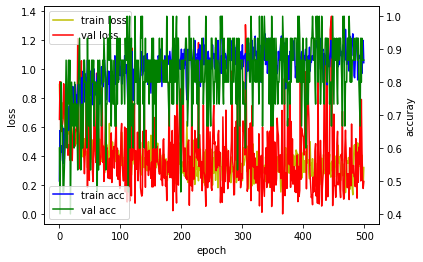

In [11]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

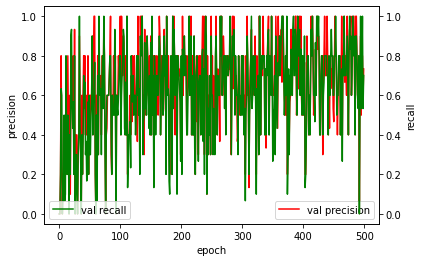

In [12]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['val_precision'], 'r', label='val precision')

acc_ax.plot(hist.history['val_recall'], 'g', label='val recall')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('precision')
acc_ax.set_ylabel('recall')

loss_ax.legend(loc='lower right')
acc_ax.legend(loc='lower left')

plt.show()

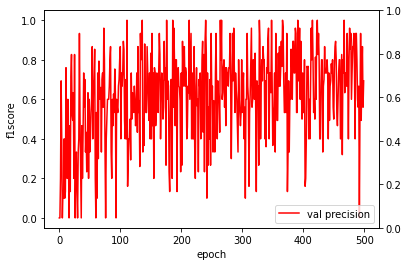

In [13]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['val_f1score'], 'r', label='val precision')



loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('f1score')


loss_ax.legend(loc='lower right')

plt.show()